# ML4N - Group Project 7
# Analysing Adversarial Attacks on Tabular Data Classifiers

In [1]:
# import needed python libraries

#%pip install -r requirements.txt

import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt 
from matplotlib import rcParams
from mpl_toolkits.mplot3d import Axes3D 


import torch # type: ignore
import torch.nn.functional as F
import random

import plotly.offline as py 
import plotly.express as px
import plotly.graph_objs as go # it's like "plt" of matplot
import plotly.subplots as tls # It's useful to we get some tools of plotly


# Change the default font family
rcParams['font.family'] = 'DejaVu Sans'

from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from plotly.subplots import make_subplots
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap
from sklearn.metrics import classification_report, confusion_matrix, RocCurveDisplay, balanced_accuracy_score, silhouette_score, adjusted_rand_score, rand_score, roc_curve, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils._testing import ignore_warnings
from art.estimators.classification import PyTorchClassifier # type: ignore
from art.attacks.evasion import FastGradientMethod, ProjectedGradientDescent # type: ignore
from collections import Counter # To do counter of some features
from torch import nn
from imblearn.over_sampling import SMOTE # type: ignore

from scipy.stats import uniform
from xgboost import XGBClassifier

#### this code, allow us to work with offline plotly version
py.init_notebook_mode(connected=True) 

#### to avoid some redundant warning during cross-validation due to parameters incompatibility and also eventual packets'versions mismatch
import warnings
warnings.filterwarnings('ignore')

# matplotlib defaults
plt.style.use("fivethirtyeight")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
    grid=True,
)

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-06-13 17:28:32.858929: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-13 17:28:35.814343: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# confusion matrix
def confusion_matri(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    tp, fp, fn, tn = cm.ravel()
    #plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='.2f', 
                xticklabels =['Bad credit','Good credit'],
                yticklabels =['Bad credit','Good credit'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted lable')
    plt.title("Confusion Matrix")
    plt.show()
    return tn,fp,fn,tp

# plotting roc-auc curve
def draw_roc(actual, proba):
    fpr, tpr, thresholds = roc_curve(actual, proba,drop_intermediate=False)
    auc_score = roc_auc_score(actual, proba)
    # plot the curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label="ROC curve(area={})".format(round(auc_score,2)))
    plt.plot([0,1],[0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(visible=True, color='wheat', linestyle='--')
    plt.legend(loc="lower right")
    plt.title("ROC-AUC Curve")
    plt.show()
    return fpr, tpr, thresholds

In [3]:
#### List of Attributes for dataset acquired from german.doc
#### good/bad is the label 1 means good customer while 2 means bad
attributes = ["Status_account", "Duration", "Credit_history","Purpose",
             "Credit_amount","Savings_account_bonds","Employment_since","Install_rate",
              "Personal_status_sex","debtors_guarantors","Present_residence_since",
              "Property","Age","Other_install_plans","Housing","No_credits","Job",
              "No_people_liable","Telephone","foreign_worker","good_bad"] 

#### Acquiring dataset from german.data file
df = pd.read_csv("statlog+german+credit+data/german.data", sep=' ', names = attributes)

In [4]:
#### Splitting the data into sets 
columns_no_label = df.columns.drop("good_bad")

X_not_encoded, X_test_not_encoded, y, y_test = train_test_split(
    df[columns_no_label], # X
    df['good_bad'], # y
    stratify = df['good_bad'], # stratify the dataset based on class labels
    train_size = 0.8, # percentage of training set
    random_state = 15 
)

#### Qualitative attributes that do not require encoding 
to_remove = ["Duration","Credit_amount","Install_rate","Present_residence_since",
             "Age","No_credits","No_people_liable","good_bad"] 

#### Creating the list with the categorical attributes to be encoded
to_be_encoded = attributes.copy()
for el in to_remove:
    to_be_encoded.remove(el)

to_remove.remove("good_bad")

#### Using One Hot Encoding to transform categorical attributes into qualitative ones
X_encoded = pd.get_dummies(X_not_encoded, columns=to_be_encoded, dtype = int)
X_test_encoded = pd.get_dummies(X_test_not_encoded, columns=to_be_encoded, dtype = int)

#### Setting bad to 0 and good to 1
mask_bad = y == 2
y = np.where(mask_bad, 0, 1)

mask_bad = y_test == 2
y_test = np.where(mask_bad, 0, 1)

#### Normalization between [0,1]
scaler = MinMaxScaler()

#### Creation of the pandas dataframe of the normalized values
X = scaler.fit_transform(X_encoded)
X_test = scaler.fit_transform(X_test_encoded)

X = pd.DataFrame(X, columns=X_encoded.columns)
X_test = pd.DataFrame(X_test, columns=X_encoded.columns)



df_encoded = pd.get_dummies(df, columns=to_be_encoded, dtype = int)
array_df_encoded = scaler.fit_transform(df_encoded)
df_normalized = pd.DataFrame(array_df_encoded, columns=df_encoded.columns)
df_normalized_no_label = df_normalized.drop(columns="good_bad")

# 2 Unsupervised exploration and clustering #

## 2.1 Dimensionality reduction for data visualization ###

In [5]:
#### PCA for Unsupervised
pca = PCA(n_components = 30)
pca.fit(df_normalized_no_label)
df_PCA = pca.transform(df_normalized_no_label)


sm = SMOTE(random_state=60)
X_SMOTE, Y_SMOTE = sm.fit_resample(df_normalized_no_label, df_normalized['good_bad'])

#### PCA for Unsupervised
pca = PCA(n_components = 30)
pca.fit(X_SMOTE)
X_PCA_SMOTE = pca.transform(X_SMOTE)

In [6]:
#### I Apply t-SNE for dimensionality reduction
perplexities = [5, 10, 20, 30, 50]
learning_rate = np.linspace(10, 1000, 5)

plt.figure(figsize=(15, 10))

for i, perplexity in enumerate(perplexities, 1):
    for lr in learning_rate:
        tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42, learning_rate = lr)
        X_tsne = tsne.fit_transform(df_normalized_no_label)
        if (perplexity == 5 and lr == 10):
            unsupervised_df_t_sne = pd.DataFrame(X_tsne, columns = ['C1', 'C2'])

<Figure size 1080x720 with 0 Axes>

## 2.2 Unsupervised Data Analysis
---

In [7]:
# confusion matrix
def confusion_matri(actual, predicted):
    cm = confusion_matrix(actual, predicted)
    tp, fp, fn, tn = cm.ravel()
    #plot confusion matrix
    plt.figure(figsize=(6,6))
    sns.heatmap(cm, annot=True, fmt='.2f', 
                xticklabels =['Bad credit','Good credit'],
                yticklabels =['Bad credit','Good credit'])
    plt.ylabel('True Label')
    plt.xlabel('Predicted lable')
    plt.title("Confusion Matrix")
    plt.show()
    return tn,fp,fn,tp

# plotting roc-auc curve
def draw_roc(actual, proba):
    fpr, tpr, thresholds = roc_curve(actual, proba,drop_intermediate=False)
    auc_score = roc_auc_score(actual, proba)
    # plot the curve
    plt.figure(figsize=(8,6))
    plt.plot(fpr, tpr, label="ROC curve(area={})".format(round(auc_score,2)))
    plt.plot([0,1],[0,1], 'k--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.grid(visible=True, color='wheat', linestyle='--')
    plt.legend(loc="lower right")
    plt.title("ROC-AUC Curve")
    plt.show()
    return fpr, tpr, thresholds

### 2.2.1 k-Means

k-Means needs as hyper-parameter the number of clusters k.
Another hyper-parameter is the initialization strategy for the centroid ``init``:
- *random*: centroids will be initialized randomly in the valid data region. You can specify the ``random_state``. Changing the random state may change the result due to a different centroid inizialization.
- *k-means++*: centroids will be equally distant from each other, leading to provably better results than random initialization.
- ndarray: if you have a clue about where centroids could be, you can pass them (i.e. their coordinates) as initialization.

Moreover, ``n_init`` is the number of times the k-means algorithm will be run with different centroid seeds. The final results will be the best output of n_init consecutive runs in terms of clustering error. 

For the tutorial, we will not perform any pre-processing step and directly apply k-Means.
To create the clusters the ``.fit()`` function creates the clustering function and clusters, by minimizing the clustering error on the data.

Here we are using n_init=1 and random initialization. Try to change the used features ``features_iris``, and the hyper-parameters ``n_clusters`` and ``random_state`` and see what changes

#### APPLYING ELBOW METHOD TO FIND THE BEST NUMBER OF CLUSTERS

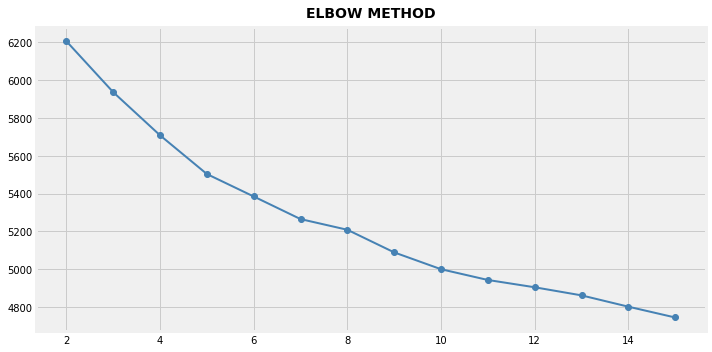

In [8]:
inertias = []
silhouette_scores = []

for i in range(2,16):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(df_PCA)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(df_PCA, kmeans.labels_))

plt.figure(figsize=(10,5))
plt.title('ELBOW METHOD')
plt.plot(np.arange(2,16),inertias, marker='o', lw=2, color='steelblue')

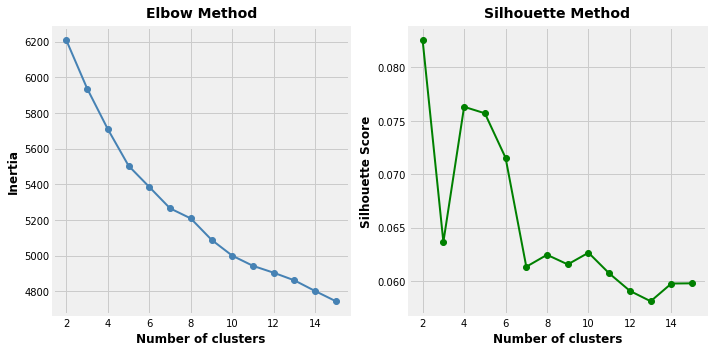

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.title('Elbow Method')
plt.plot(np.arange(2, 16), inertias, marker='o', lw=2, color='steelblue')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.grid(True)

plt.subplot(1, 2, 2)
plt.title('Silhouette Method')
plt.plot(np.arange(2, 16), silhouette_scores, marker='o', lw=2, color='green')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.grid(True)

plt.tight_layout()
plt.show()

#### ALTERNATIVE METHOD: SILHOUTE SCORE WITH RANDOM SAMPLING

<Axes: xlabel='seed', ylabel='num_cluster'>

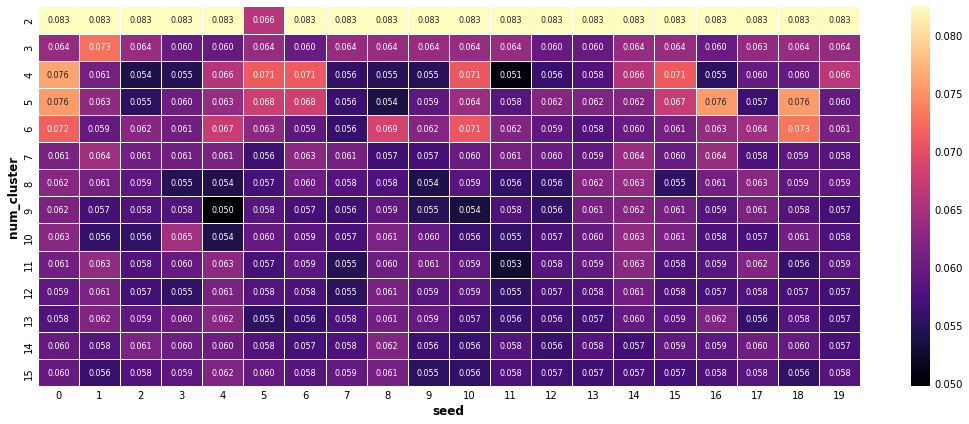

In [10]:
results = []

for i in range(2,16):
    for r in range(20):
        kmeans = KMeans(n_clusters=i, random_state=r)
        c_labels = kmeans.fit_predict(df_PCA)
        sil_ave = silhouette_score(df_PCA, c_labels)
        results.append([i, r, sil_ave])
        
res_df = pd.DataFrame(results, columns=['num_cluster', 'seed', 'sil_score'])
pivot_kmeans = pd.pivot_table(res_df, index='num_cluster', columns='seed', values='sil_score')

plt.figure(figsize=(15,6))
plt.tight_layout
sns.heatmap(pivot_kmeans, annot=True, linewidths=0.5, fmt='.3f', cmap='magma', annot_kws={"size":8})

In [11]:
# Funzione per trovare il miglior numero di cluster per k-Means usando silhouette score
def optimal_k_means(df_PCA):
    silhouette_scores = []
    K = range(2, 11)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        labels = kmeans.fit_predict(df_PCA)
        score = silhouette_score(df_PCA, labels)
        silhouette_scores.append(score)
    best_k = K[silhouette_scores.index(max(silhouette_scores))]
    return best_k, silhouette_scores

# Trovare il miglior numero di cluster per k-Means
best_k, silhouette_scores = optimal_k_means(df_PCA)
print(f"Best number of clusters for k-Means: {best_k}")

Best number of clusters for k-Means: 2


#### AT 2 NUMBER OF CLUSTERS

#### 2.2.1.1 k-Means - PCA

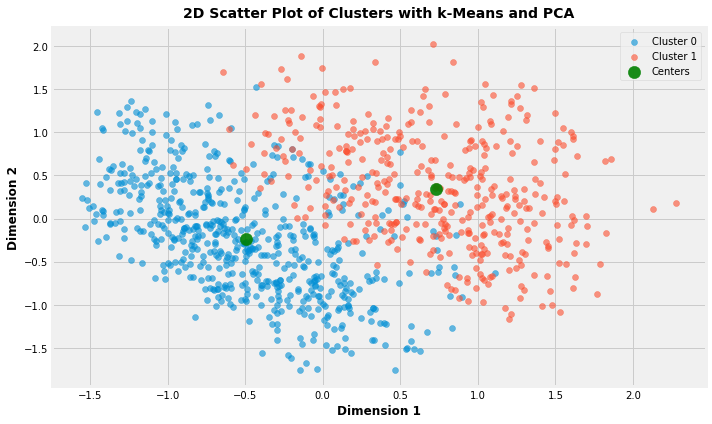

In [12]:
# Eseguire k-Means con il miglior numero di cluster
# Eseguire k-Means
km = KMeans(n_clusters=2, random_state=0, n_init=10)
clusters = km.fit_predict(df_PCA)


# Plot 2D
plt.figure(figsize=(10, 6))

# Plot clusters
plt.scatter(df_PCA[clusters == 0, 0], df_PCA[clusters == 0, 1], label='Cluster 0', alpha=0.6)
plt.scatter(df_PCA[clusters == 1, 0], df_PCA[clusters == 1, 1], label='Cluster 1', alpha=0.6)

# Plot centers if given
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='g', s=150, alpha=0.9, label="Centers")

# Adding labels and legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.title('2D Scatter Plot of Clusters with k-Means and PCA')
plt.show()

### Unsupervised clustering performance

After having computed the clusters, we can obtain clustering performance metrics:

- the metric minimized in the clustering algorithm for the empirical data (for k-Means, the mean squared distance of the points from their own centroid)
- the silhouette to measure the similarity of a sample to its own cluster, compared to other clusters (<a href="https://en.wikipedia.org/wiki/Silhouette_(clustering)">Wiki</a>)

See how the results change by changing the hyper-parameters

In [13]:
#Sum of squared distances of samples to their closest cluster center.
print("Sum of squared distances of the samples from their centroid: ", km.inertia_)
# If we divide it by number of sample m, it is the clustering error we have seen in theoretical lectures
print("Mean squared distances of the samples from their centroid: ", km.inertia_/len(df_PCA))
silhouette_avg_kmeans = silhouette_score(df_PCA, km.labels_)
print(f"Silhouette Score for k-Means with PCA: {silhouette_avg_kmeans}")
# Creare un DataFrame pandas contenente sia df_umap che le etichette dei cluster
df_c = pd.DataFrame(df_PCA)  
df_c['kmeans_cluster'] = km.labels_

# Caratterizzazione dei cluster per k-Means
print("\nCharacteristics of k-Means clusters:\n")
df_c.groupby('kmeans_cluster').mean()

Sum of squared distances of the samples from their centroid:  6206.278309522074
Mean squared distances of the samples from their centroid:  6.206278309522074
Silhouette Score for k-Means with PCA: 0.08251455661515908

Characteristics of k-Means clusters:



,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
kmeans_cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.495424,-0.232779,0.155279,0.133162,-0.093188,0.008100,0.107946,-0.005162,-0.009684,-0.060638,...,-0.009643,-0.005761,-0.002812,0.005170,0.000773,0.003999,0.006132,0.000708,-0.000786,0.003949
1,0.730873,0.343407,-0.229075,-0.196447,0.137475,-0.011949,-0.159246,0.007615,0.014287,0.089456,...,0.014226,0.008499,0.004149,-0.007626,-0.001140,-0.005900,-0.009046,-0.001045,0.001160,-0.005826


1. **Silhouette Score**:
	- The Silhouette Score measures how similar each point is to its own cluster compared to other clusters.
	- The formula for the Silhouette Score of a single point is:
      \[
      s = \frac{b - a}{\max(a, b)}
      \]
      where:
        - \(a\) is the mean distance between a point and all other points in the same cluster.
        - \(b\) is the mean distance between a point and all points in the nearest cluster that the point is not part of.

2. **Output of Silhouette Score**:
    - `print(f"Silhouette Score for k-Means: {silhouette_avg_kmeans}")`:
        - Prints the average Silhouette Score value for all points in the dataset.

### Interpreting the Result:

- **Silhouette Score**:
    - The Silhouette Score ranges from -1 to 1.
    - Values close to 1 indicate that points are well-clustered within their clusters and clusters are well-separated.
    - Values close to 0 indicate that points are on the boundary between clusters.
    - Negative values indicate that points may have been assigned to the wrong cluster.

### What's Considered Optimal?

- **Silhouette Score > 0.5**: Indicates good cluster separation and well-clustered points. This is considered a good result.
- **Silhouette Score between 0.3 and 0.5**: Indicates moderate cluster separation. It may be acceptable, but further parameter tuning or preprocessing might be necessary.
- **Silhouette Score < 0.3**: Indicates poorly defined clusters. It's advisable to review algorithm parameters or data preprocessing.

### Expected Outcome:

- After running the code, you'll obtain a Silhouette Score value.
- A high value (ideally > 0.5) suggests well-separated clusters and well-clustered points.
- A low value suggests considering:
    - Reviewing k-Means parameters (such as the number of clusters `k`).
    - Reviewing data preprocessing.
    - Trying other clustering algorithms.

We can also compare clusters with the ground-truth labels (or with a different clustering):
- Rand index (RI): given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the Rand index is a function that measures the similarity of the two assignments,
- Adjusted rand index (ARI): corrects the RI for chance and will give a baseline at 0.

In [14]:
# To compute the rand index and adjusted rand index sklearn provides the rand_score and adjusted_rand_score functions
rand_score_result = rand_score(df_normalized["good_bad"], km.labels_)
adj_rand_score_result = adjusted_rand_score(df_normalized["good_bad"], km.labels_)

print("RI between clustering and given classes is ",rand_score_result)
print("ARI between clustering and given classes is ",adj_rand_score_result)

RI between clustering and given classes is  0.5004684684684685
ARI between clustering and given classes is  -0.004804311811683012


The output results will consist of two numerical values printed on the console:

1. **RI between clustering and given classes**: This value represents the Rand Index between the labels predicted by the clustering and the actual labels. The Rand Index measures how much pairs of samples are assigned to the same cluster or class in both the predicted and actual groupings. It can range from 0 to 1, where 1 indicates perfect agreement between cluster and class assignments.

2. **ARI between clustering and given classes**: This value represents the Adjusted Rand Index, which takes into account chance agreement by adjusting the Rand Index for randomness. Like the Rand Index, it can range from -1 to 1, where 1 indicates perfect agreement between cluster and class assignments.

The evaluation of these results depends on the nature of your problem and the quality of your class labels. Some general considerations are:

- **Values close to 1**: Indicate that the clustering has grouped the data very similarly to the real class labels. This is a desirable outcome.
- **Values around 0**: Indicate no agreement between class labels and clustering groupings. This may mean that the clustering failed to capture the data structure significantly or that the class labels are uninformative.
- **Negative values**: Indicate that the clustering performs worse than random assignment of class labels. This could happen if the clustering goes opposite to the real data structure.

Moreover, it's important to consider the context of your problem and the data distribution. For example, in the presence of overlapping clusters or highly imbalanced classes, you might expect different results. Ideally, you would want to compare these values with other clustering evaluation metrics and consider the specific context of your problem.

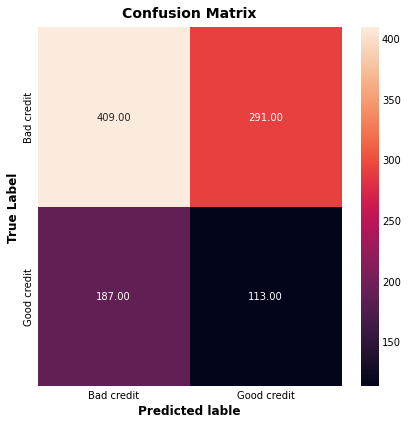

Confusion Matrix:
 [[409 291]
 [187 113]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.58      0.63       700
         1.0       0.28      0.38      0.32       300

    accuracy                           0.52      1000
   macro avg       0.48      0.48      0.48      1000
weighted avg       0.56      0.52      0.54      1000



In [15]:
# confusion matrix of logit model
confusion_matri(df_normalized['good_bad'], km.labels_)
# Evaluate the purity of the clusters
conf_matrix = confusion_matrix(df_normalized['good_bad'], km.labels_)
print("Confusion Matrix:\n", conf_matrix)

report = classification_report(df_normalized['good_bad'], km.labels_)
print("Classification Report:\n", report)

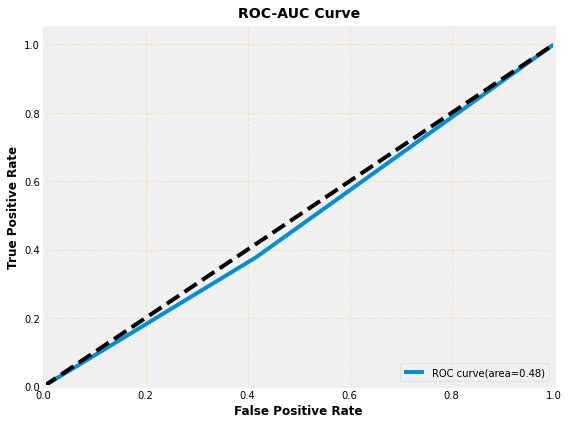

(array([0.        , 0.41571429, 1.        ]),
 array([0.        , 0.37666667, 1.        ]),
 array([inf,  1.,  0.]))

In [16]:
draw_roc(df_normalized['good_bad'], km.labels_)

#### 2.2.1.2 k-Means - PCA with SMOTE

Sum of squared distances of the samples from their centroid:  8237.333523126705
Mean squared distances of the samples from their centroid:  5.883809659376218
Silhouette Score for k-Means with PCA: 0.08534351615788505


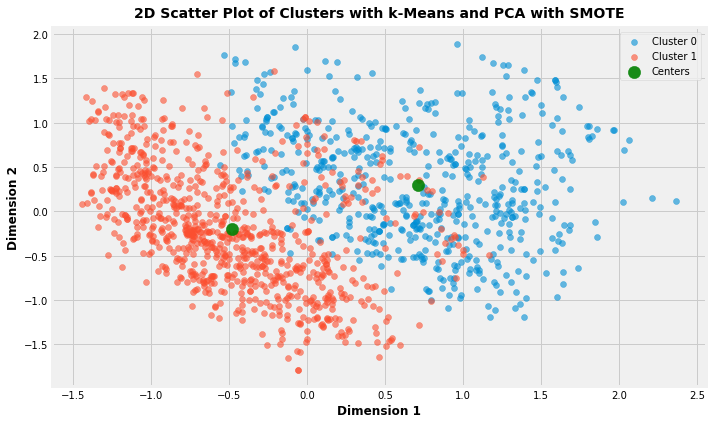

In [17]:
# Eseguire k-Means con il miglior numero di cluster
# Eseguire k-Means
km = KMeans(n_clusters=2, random_state=0, n_init=10)
clusters = km.fit_predict(X_PCA_SMOTE)
centers = km.cluster_centers_


#Sum of squared distances of samples to their closest cluster center.
print("Sum of squared distances of the samples from their centroid: ", km.inertia_)
# If we divide it by number of sample m, it is the clustering error we have seen in theoretical lectures
print("Mean squared distances of the samples from their centroid: ", km.inertia_/len(X_PCA_SMOTE))
silhouette_avg_kmeans = silhouette_score(X_PCA_SMOTE, km.labels_)
print(f"Silhouette Score for k-Means with PCA: {silhouette_avg_kmeans}")

# Plot 2D
plt.figure(figsize=(10, 6))

# Plot clusters
plt.scatter(X_PCA_SMOTE[clusters == 0, 0], X_PCA_SMOTE[clusters == 0, 1], label='Cluster 0', alpha=0.6)
plt.scatter(X_PCA_SMOTE[clusters == 1, 0], X_PCA_SMOTE[clusters == 1, 1], label='Cluster 1', alpha=0.6)

# Plot centers if given
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='g', s=150, alpha=0.9, label="Centers")

# Adding labels and legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.title('2D Scatter Plot of Clusters with k-Means and PCA with SMOTE')
plt.show()

In [18]:
# To compute the rand index and adjusted rand index sklearn provides the rand_score and adjusted_rand_score functions
rand_score_result = rand_score(Y_SMOTE, km.labels_)
adj_rand_score_result = adjusted_rand_score(Y_SMOTE, km.labels_)

print("RI between clustering and given classes is ",rand_score_result)
print("ARI between clustering and given classes is ",adj_rand_score_result)

RI between clustering and given classes is  0.5000112325130195
ARI between clustering and given classes is  4.935195134919437e-05


In [19]:
# Creare un DataFrame pandas contenente sia df_umap che le etichette dei cluster
df_cs = pd.DataFrame(X_PCA_SMOTE)  
df_cs['kmeans_cluster'] = km.labels_

# Caratterizzazione dei cluster per k-Means
print("\nCharacteristics of k-Means clusters:\n")
df_cs.groupby('kmeans_cluster').mean()


Characteristics of k-Means clusters:



,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
kmeans_cluster,,,,,,,,,,,,,,,,,,,,,
0,0.709163,0.292716,-0.364109,-0.063416,-0.083406,-0.103671,-0.159946,-0.014220,0.054292,-0.021471,...,0.016373,-0.000827,-0.002089,-0.006372,0.001885,-0.003431,0.008219,0.001180,0.003689,0.004159
1,-0.477012,-0.196892,0.244914,0.042656,0.056102,0.069733,0.107586,0.009565,-0.036519,0.014442,...,-0.011013,0.000556,0.001405,0.004286,-0.001268,0.002308,-0.005528,-0.000794,-0.002481,-0.002798


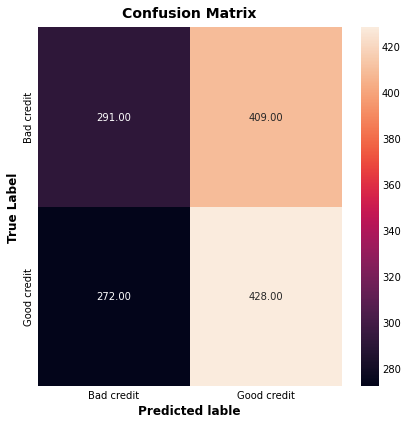

Confusion Matrix:
 [[291 409]
 [272 428]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.52      0.42      0.46       700
         1.0       0.51      0.61      0.56       700

    accuracy                           0.51      1400
   macro avg       0.51      0.51      0.51      1400
weighted avg       0.51      0.51      0.51      1400



In [20]:
# confusion matrix of logit model
confusion_matri(Y_SMOTE, km.labels_)
# Evaluate the purity of the clusters
conf_matrix = confusion_matrix(Y_SMOTE, km.labels_)
print("Confusion Matrix:\n", conf_matrix)

report = classification_report(Y_SMOTE, km.labels_)
print("Classification Report:\n", report)

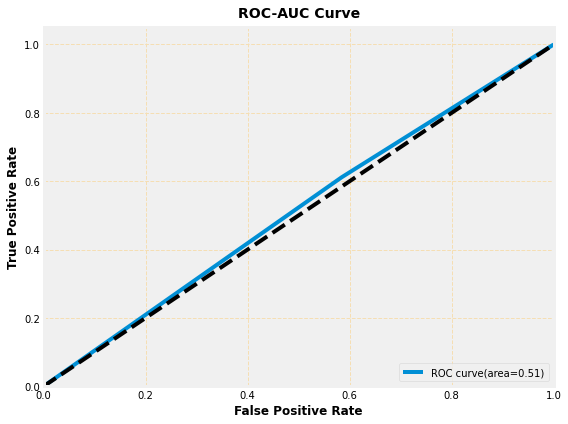

(array([0.        , 0.58428571, 1.        ]),
 array([0.        , 0.61142857, 1.        ]),
 array([inf,  1.,  0.]))

In [21]:
draw_roc(Y_SMOTE, km.labels_)

#### 2.2.1.3 k-Means - t-SNE

Sum of squared distances of the samples from their centroid:  975035.5
Mean squared distances of the samples from their centroid:  975.0355
Silhouette Score for k-Means with PCA: 0.374947726726532


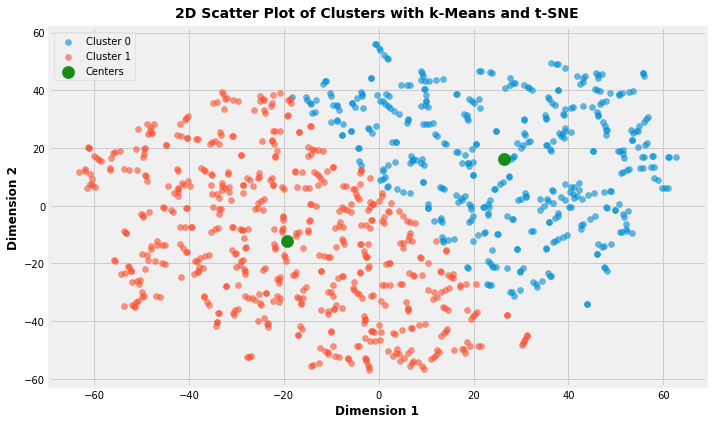

In [22]:
# Eseguire k-Means con il miglior numero di cluster
# Eseguire k-Means
km = KMeans(n_clusters=2, random_state=0, n_init=10)
clusters = km.fit_predict(unsupervised_df_t_sne)
centers = km.cluster_centers_


# Valutazione della qualità dei cluster per k-Means
#Sum of squared distances of samples to their closest cluster center.
print("Sum of squared distances of the samples from their centroid: ", km.inertia_)
# If we divide it by number of sample m, it is the clustering error we have seen in theoretical lectures
print("Mean squared distances of the samples from their centroid: ", km.inertia_/len(unsupervised_df_t_sne))
silhouette_avg_kmeans = silhouette_score(unsupervised_df_t_sne, km.labels_)
print(f"Silhouette Score for k-Means with PCA: {silhouette_avg_kmeans}")

# Plot 2D
plt.figure(figsize=(10, 6))

# Plot clusters
plt.scatter(unsupervised_df_t_sne.iloc[clusters == 0, 0], unsupervised_df_t_sne.iloc[clusters == 0, 1], label='Cluster 0', alpha=0.6)
plt.scatter(unsupervised_df_t_sne.iloc[clusters == 1, 0], unsupervised_df_t_sne.iloc[clusters == 1, 1], label='Cluster 1', alpha=0.6)

# Plot centers if given
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='g', s=150, alpha=0.9, label="Centers")

# Adding labels and legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.title('2D Scatter Plot of Clusters with k-Means and t-SNE')
plt.show()

In [23]:
# To compute the rand index and adjusted rand index sklearn provides the rand_score and adjusted_rand_score functions
rand_score_result = rand_score(df_normalized["good_bad"], km.labels_)
adj_rand_score_result = adjusted_rand_score(df_normalized["good_bad"], km.labels_)

print("RI between clustering and given classes is ",rand_score_result)
print("ARI between clustering and given classes is ",adj_rand_score_result)

RI between clustering and given classes is  0.5015495495495496
ARI between clustering and given classes is  -0.0006210659287190106


In [24]:
unsupervised_df_t_sne['kmeans_cluster'] = km.labels_

# Caratterizzazione dei cluster per k-Means
print("\nCharacteristics of k-Means clusters:\n")
unsupervised_df_t_sne.groupby('kmeans_cluster').mean()


Characteristics of k-Means clusters:



,C1,C2
kmeans_cluster,,
0,26.515358,16.302618
1,-19.275200,-12.370306


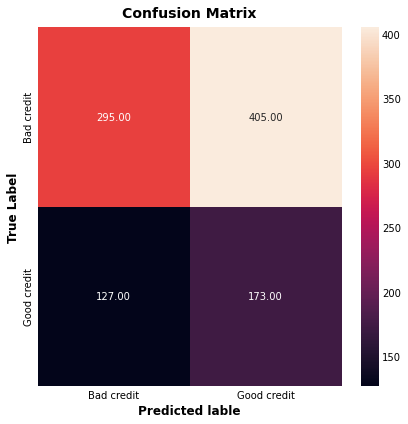

Confusion Matrix:
 [[295 405]
 [127 173]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.70      0.42      0.53       700
         1.0       0.30      0.58      0.39       300

    accuracy                           0.47      1000
   macro avg       0.50      0.50      0.46      1000
weighted avg       0.58      0.47      0.49      1000



In [25]:
# confusion matrix of logit model
confusion_matri(df_normalized["good_bad"], km.labels_)
# Evaluate the purity of the clusters
conf_matrix = confusion_matrix(df_normalized["good_bad"], km.labels_)
print("Confusion Matrix:\n", conf_matrix)

report = classification_report(df_normalized["good_bad"], km.labels_)
print("Classification Report:\n", report)

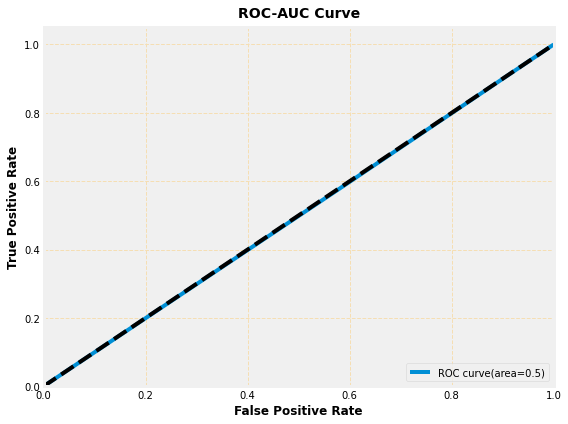

(array([0.        , 0.57857143, 1.        ]),
 array([0.        , 0.57666667, 1.        ]),
 array([inf,  1.,  0.]))

In [26]:
draw_roc(df_normalized["good_bad"], km.labels_)

#### 2.2.1.3 k-Means - UMAP

UMAP (Uniform Manifold Approximation and Projection) is a dimensionality reduction technique that can help improve cluster separation.

Best Silhouette Score: 0.45570531487464905 with params: {'n_neighbors': 15, 'min_dist': 0.0, 'best_k': 2}


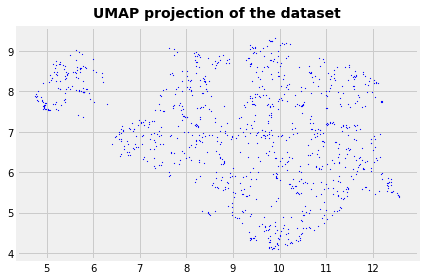

In [27]:
import itertools

def find_best_k(umap_data, k_range):
    best_k = None
    best_score = -1
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
        kmeans.fit(umap_data)
        score = silhouette_score(umap_data, kmeans.labels_)
        if score > best_score:
            best_score = score
            best_k = k
    return best_k, best_score

best_score = -1
best_params = {}
best_umap_projection = None
k_range = range(2, 11)  # Range of k values to try

# Iterate over all combinations of n_neighbors and min_dist
for n, d in itertools.product([5, 15, 25, 50], [0.0, 0.1, 0.3, 0.5]):
    umap_reducer = umap.UMAP(n_neighbors=n, min_dist=d, random_state=42)
    df_umap = umap_reducer.fit_transform(df_normalized_no_label)
    
    # Find the best k for the current UMAP projection
    current_best_k, current_best_score = find_best_k(df_umap, k_range)
    
    if current_best_score > best_score:
        best_score = current_best_score
        best_params = {'n_neighbors': n, 'min_dist': d, 'best_k': current_best_k}
        best_umap_projection = df_umap

print(f"Best Silhouette Score: {best_score} with params: {best_params}")

# Visualize the best UMAP projection with optimal clustering
best_k = best_params['best_k']
kmeans = KMeans(n_clusters=best_k, random_state=0, n_init=10)
kmeans.fit(best_umap_projection)

# Visualizzazione della riduzione
plt.scatter(best_umap_projection[:, 0], best_umap_projection[:, 1], c='blue', s=0.5)
plt.title('UMAP projection of the dataset')
plt.show()


Sum of squared distances of the samples from their centroid:  2618.251708984375
Mean squared distances of the samples from their centroid:  2.618251708984375


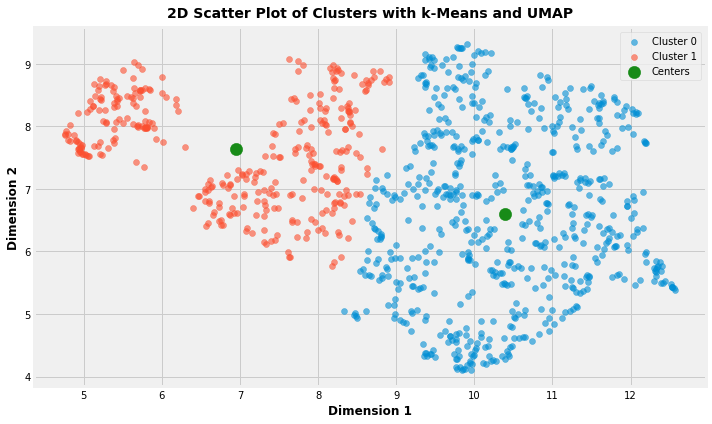

In [28]:
# Riduzione della dimensionalità con UMAP
umap_reducer = umap.UMAP(n_neighbors=15, min_dist=0.0, random_state=42)
df_umap = umap_reducer.fit_transform(best_umap_projection)
# Eseguire k-Means con il miglior numero di cluster
# Eseguire k-Means
km = KMeans(n_clusters=2, random_state=0, n_init=10)
clusters = km.fit_predict(best_umap_projection)


# Valutazione della qualità dei cluster per k-Means
#Sum of squared distances of samples to their closest cluster center.
print("Sum of squared distances of the samples from their centroid: ", km.inertia_)
# If we divide it by number of sample m, it is the clustering error we have seen in theoretical lectures
print("Mean squared distances of the samples from their centroid: ", km.inertia_/len(df_normalized_no_label))

# Plot 2D
plt.figure(figsize=(10, 6))

# Plot clusters
plt.scatter(best_umap_projection[clusters == 0, 0], best_umap_projection[clusters == 0, 1], label='Cluster 0', alpha=0.6)
plt.scatter(best_umap_projection[clusters == 1, 0], best_umap_projection[clusters == 1, 1], label='Cluster 1', alpha=0.6)

# Plot centers if given
centers = km.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='g', s=150, alpha=0.9, label="Centers")

# Adding labels and legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.title('2D Scatter Plot of Clusters with k-Means and UMAP')
plt.show()

In [29]:
#Sum of squared distances of samples to their closest cluster center.
print("Sum of squared distances of the samples from their centroid: ", km.inertia_)
# If we divide it by number of sample m, it is the clustering error we have seen in theoretical lectures
print("Mean squared distances of the samples from their centroid: ", km.inertia_/len(df_umap))
silhouette_avg_kmeans = silhouette_score(df_umap, km.labels_)
print(f"Silhouette Score for k-Means with PCA: {silhouette_avg_kmeans}")
# Creare un DataFrame pandas contenente sia df_umap che le etichette dei cluster
df_umap_with_clusters = pd.DataFrame(df_umap, columns=['UMAP Dimension 1', 'UMAP Dimension 2'])  # Modifica le colonne in base al numero di dimensioni prodotte da UMAP
df_umap_with_clusters['kmeans_cluster'] = km.labels_

df_umap_with_clusters['kmeans_cluster'] = km.labels_

# Caratterizzazione dei cluster per k-Means
print("\nCharacteristics of k-Means clusters:\n")
df_umap_with_clusters.groupby('kmeans_cluster').mean()

Sum of squared distances of the samples from their centroid:  2618.251708984375
Mean squared distances of the samples from their centroid:  2.618251708984375
Silhouette Score for k-Means with PCA: 0.2392856478691101

Characteristics of k-Means clusters:



,UMAP Dimension 1,UMAP Dimension 2
kmeans_cluster,,
0,6.367593,4.465436
1,7.783285,4.727473


We can also compare clusters with the ground-truth labels (or with a different clustering):
- Rand index (RI): given the knowledge of the ground truth class assignments labels_true and our clustering algorithm assignments of the same samples labels_pred, the Rand index is a function that measures the similarity of the two assignments,
- Adjusted rand index (ARI): corrects the RI for chance and will give a baseline at 0.

In [30]:
# To compute the rand index and adjusted rand index sklearn provides the rand_score and adjusted_rand_score functions
rand_score_result = rand_score(df_normalized["good_bad"], clusters)
adj_rand_score_result = adjusted_rand_score(df_normalized["good_bad"], clusters)

print("RI between clustering and given classes is ",rand_score_result)
print("ARI between clustering and given classes is ",adj_rand_score_result)

RI between clustering and given classes is  0.5101681681681681
ARI between clustering and given classes is  0.006437590894917984


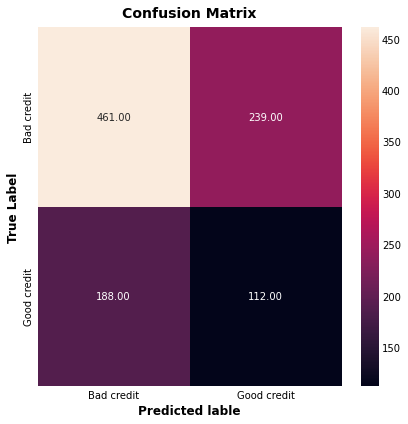

Confusion Matrix:
 [[461 239]
 [188 112]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.71      0.66      0.68       700
         1.0       0.32      0.37      0.34       300

    accuracy                           0.57      1000
   macro avg       0.51      0.52      0.51      1000
weighted avg       0.59      0.57      0.58      1000



In [31]:
# confusion matrix of logit model
confusion_matri(df_normalized["good_bad"], clusters)
# Evaluate the purity of the clusters
conf_matrix = confusion_matrix(df_normalized["good_bad"], clusters)
print("Confusion Matrix:\n", conf_matrix)

report = classification_report(df_normalized["good_bad"], clusters)
print("Classification Report:\n", report)

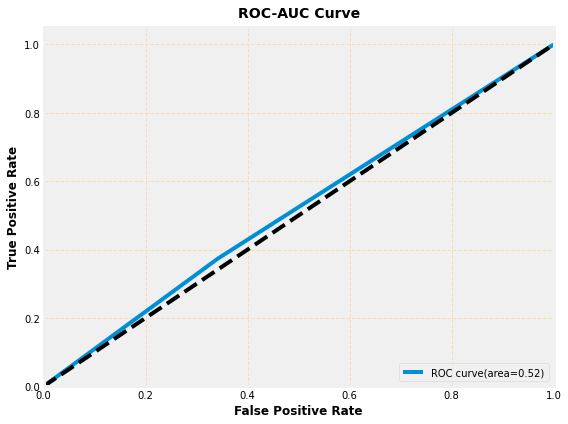

(array([0.        , 0.34142857, 1.        ]),
 array([0.        , 0.37333333, 1.        ]),
 array([inf,  1.,  0.]))

In [32]:
draw_roc(df_normalized["good_bad"], clusters)

### 2.2.2 Gaussian Mixture Model

GMM need as hyper-parameter the number of clusters k (``n_components``).

Another hyper-parameter is the initialization strategy for the centroids ``init_params``:
- ‘kmeans’ : responsibilities are initialized using k-Means.
- ‘random’ : responsibilities are initialized randomly.

For the tutorial, we will not perform any pre-processing step and directly apply GMM.
To create the clusters the ``.fit()`` function creates the clustering function and clusters, by maximizing the log-likelihood on the data.

In [33]:
# Gaussian Mixture Model with Grid Search
param_grid = {
    'n_components': [2],
    'covariance_type': ['full', 'tied', 'diag', 'spherical'],
    'tol': [1e-3, 1e-4, 1e-5],
    'reg_covar': [1e-6, 1e-5, 1e-4]
}

#### 2.2.2.1 Gaussian Mixture Model with PCA

In [34]:
gmm = GaussianMixture(n_components=2, random_state=0, n_init=10)
clusters = gmm.fit_predict(df_PCA)

In [40]:
gmm = GaussianMixture(random_state=15)
grid_search = GridSearchCV(gmm, param_grid, cv=5, scoring='neg_log_loss')
grid_search.fit(df_PCA)

# Best model
best_gmm = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

# Predict cluster labels
cluster_labels = best_gmm.predict(df_PCA)

Best Parameters: {'covariance_type': 'full', 'n_components': 2, 'reg_covar': 1e-06, 'tol': 0.001}


### Unsupervised clustering performance

After having computed the clusters, measure the log-likelihood and the average silhouette. 
See how the results change by changing the hyper-parameters.

Silhouette Score: 0.08251455661515908


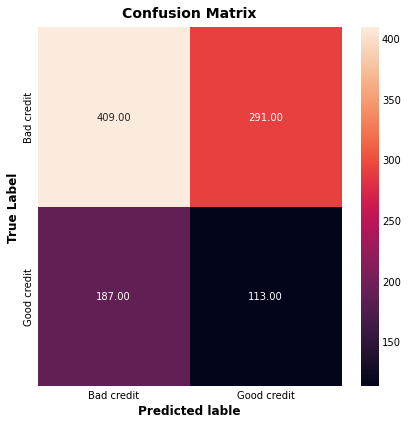

Confusion Matrix:
 [[409 291]
 [187 113]]
Classification Report:
               precision    recall  f1-score   support

         0.0       0.69      0.58      0.63       700
         1.0       0.28      0.38      0.32       300

    accuracy                           0.52      1000
   macro avg       0.48      0.48      0.48      1000
weighted avg       0.56      0.52      0.54      1000

Cluster Purity:
 [0.58428571 0.62333333]


In [41]:
# Add the cluster labels to the dataframe
df_cgmm = df_normalized.copy()
df_cgmm['Cluster'] = cluster_labels


# Evaluate the quality of the clusters
sil_score = silhouette_score(df_PCA, cluster_labels)
print("Silhouette Score:", sil_score)

# confusion matrix of logit model
confusion_matri(df_normalized['good_bad'], df_cgmm['Cluster'])
# Evaluate the purity of the clusters
conf_matrix = confusion_matrix(df_normalized['good_bad'], df_cgmm['Cluster'])
print("Confusion Matrix:\n", conf_matrix)

report = classification_report(df_normalized['good_bad'], df_cgmm['Cluster'])
print("Classification Report:\n", report)

# Potential implications based on purity
purity = np.max(conf_matrix, axis=1) / np.sum(conf_matrix, axis=1)
print("Cluster Purity:\n", purity)

No Means


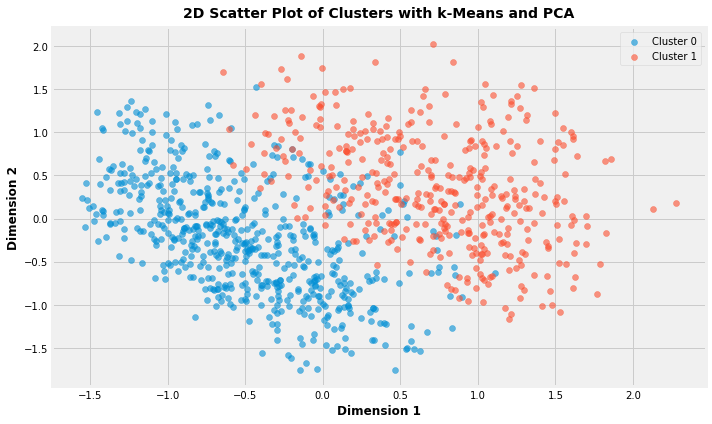

In [50]:
# Plot 2D
plt.figure(figsize=(10, 6))

# Plot clusters
plt.scatter(df_PCA[clusters == 0, 0], df_PCA[clusters == 0, 1], label='Cluster 0', alpha=0.6)
plt.scatter(df_PCA[clusters == 1, 0], df_PCA[clusters == 1, 1], label='Cluster 1', alpha=0.6)

# Plot centers if given
try:
    centers = gmm.means_
    plt.scatter(centers[:, 0], centers[:, 1], c='g', s=150, alpha=0.9, label="Centers")
except:
    print('No Means')

# Adding labels and legend
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.legend()

plt.title('2D Scatter Plot of Clusters with k-Means and PCA')
plt.show()

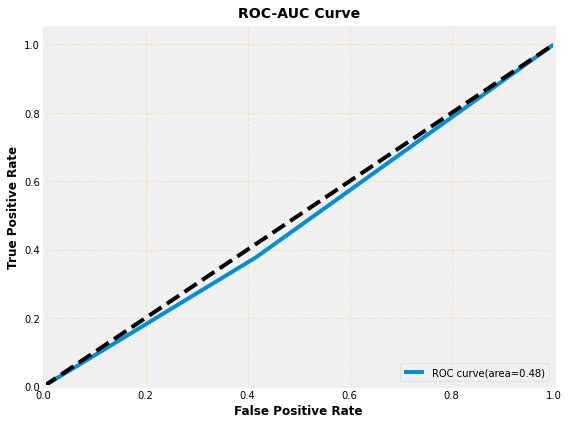

(array([0.        , 0.41571429, 1.        ]),
 array([0.        , 0.37666667, 1.        ]),
 array([inf,  1.,  0.]))

In [51]:
draw_roc(df_normalized['good_bad'], df_cgmm['Cluster'])